In [1]:
import sys
import os
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths, Subject, print_first_lvl_params

# Parameters

In [2]:
statistic = 'z_score'
multiple_comp_corr = 'fpr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rsa_no_iti_20250310'
outpur_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/second_level/stim_type_20250424'

# First level parameters

In [3]:
print_first_lvl_params(first_level_dir)

model_name: rsa_no_iti
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
motion_type: basic
include_physio: True
brain_mask: True
fd_thresh: 0.5
std_dvars_thresh: 2
exclusion_threshold: 0.2
scrub: dummies
duration: all
iti_included: False


# Load First level data

In [4]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [5]:
stimuli = [1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
betamap_dict = {}
previous_found_subs = None

for stim in stimuli:
    betamap_paths, found_subs = get_betamap_paths(sub_ids, first_level_dir, run, f"sub-{{sub_id}}_run-{{run}}_betamap_first_stim_presentation_{stim}.nii.gz")
    betamap_dict[stim] = betamap_paths
    print(f"Found {len(betamap_paths)} beta maps for stimulus {stim}")
    
    if previous_found_subs is None:
        previous_found_subs = found_subs
    else:
        if found_subs != previous_found_subs:
            print(f"Warning: found_subs list has changed for stimulus {stim}")

Found 57 beta maps for stimulus 1
Found 57 beta maps for stimulus 2
Found 57 beta maps for stimulus 3
Found 57 beta maps for stimulus 4
Found 57 beta maps for stimulus 5
Found 57 beta maps for stimulus 6
Found 57 beta maps for stimulus 7
Found 57 beta maps for stimulus 8


In [7]:
all_paths = [path for paths in betamap_dict.values() for path in paths]

# Look at combined stim presentation

In [8]:
all_stim_presentation = [image.load_img(path) for path in all_paths]
X_sc = pd.DataFrame([1] * len(all_stim_presentation), columns=['button_press'])

In [9]:
second_level_model_sc = SecondLevelModel().fit(all_stim_presentation, design_matrix=X_sc)

In [10]:
SC_WB_zmap = second_level_model_sc.compute_contrast(output_type=statistic)

In [11]:
SC_WB_thresholded_map, SC_WB_threshold = threshold_stats_img(SC_WB_zmap, alpha=alpha, height_control='bonferroni')#, cluster_threshold=30)
print(f"RL whole brain threshold: {SC_WB_threshold:.3f}")

RL whole brain threshold: 4.957


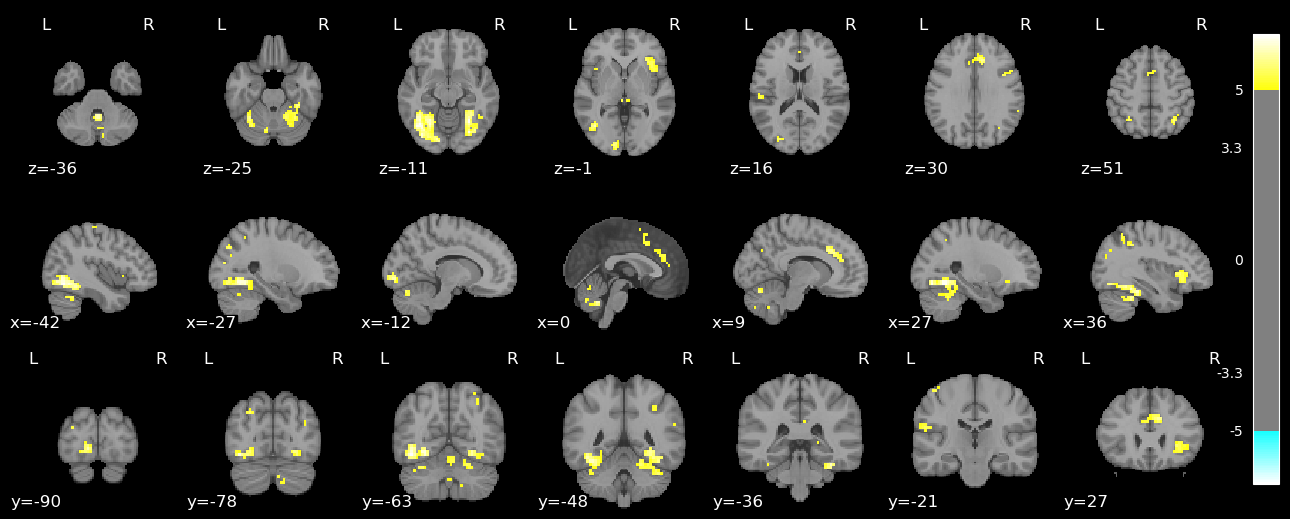

In [12]:
plot_stat_map(SC_WB_zmap, threshold=SC_WB_threshold, black_bg=True, display_mode='mosaic', title='')

# Get subject's stim mapping

In [13]:
stim_names = ['circle',
			'female face',
			'male face',
			'hand (back)',
			'hand (palm)',
			'house 1',
			'house 2',
			'triangle']

In [14]:
subjects = [Subject(base_dir, sub_id, include_modeling=False, include_imaging=False) for sub_id in found_subs]

/home/ubuntu/repos/learning-habits-analysis/results_notebooks/../utils/data.py:178: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")


In [15]:
stim_maps = {
    sub.sub_id[-2:]: dict(zip(stim_names, sub.stimuli['stim_assignment']))
    for sub in subjects
}
stim_maps['04']

{'circle': 8,
 'female face': 5,
 'male face': 3,
 'hand (back)': 2,
 'hand (palm)': 7,
 'house 1': 4,
 'house 2': 6,
 'triangle': 1}

# 2nd level model

In [16]:
categories = ['face', 'house', 'hand', 'figure']

In [17]:
def find_path(paths, subject, stim):
    pattern = rf"sub-{subject}.+stim_presentation_{stim}\.nii\.gz"
    matches = [p for p in paths if re.search(pattern, p)]

    if not matches:
        raise ValueError(f"No match found for subject {subject} and stimulus {stim}.")
    
    return matches[0]  # Since we assume exactly one match

In [18]:
face_stimuli = ['female face', 'male face']
house_stimuli = ['house 1', 'house 2']
hand_stimuli = ['hand (back)', 'hand (palm)']
figure_stimuli = ['triangle', 'circle']

face_betamaps = []
house_betamaps = []
hand_betamaps = []
figure_betamaps = []
for sub in subjects:
    for stim in face_stimuli:
        face_betamaps.append(find_path(all_paths, sub.sub_id[-2:], stim_maps.get(sub.sub_id[-2:], None).get(stim)))
    for stim in house_stimuli:
        house_betamaps.append(find_path(all_paths, sub.sub_id[-2:], stim_maps.get(sub.sub_id[-2:], None).get(stim)))
    for stim in hand_stimuli:
        hand_betamaps.append(find_path(all_paths, sub.sub_id[-2:], stim_maps.get(sub.sub_id[-2:], None).get(stim)))
    for stim in figure_stimuli:
        figure_betamaps.append(find_path(all_paths, sub.sub_id[-2:], stim_maps.get(sub.sub_id[-2:], None).get(stim)))

In [19]:
# check that all paths are unique and that they are all assigned to one of the four categories
assert set(all_paths) == set(face_betamaps + house_betamaps + hand_betamaps + figure_betamaps)

In [20]:
# Stim 8 vs stim 1
face_imgs = [image.load_img(path) for path in face_betamaps]
house_imgs = [image.load_img(path) for path in house_betamaps]
hand_imgs = [image.load_img(path) for path in hand_betamaps]
figure_imgs = [image.load_img(path) for path in figure_betamaps]

# put all images together
all_imgs = face_imgs + house_imgs + hand_imgs + figure_imgs

conditions = ['face'] * len(face_imgs) + ['house'] * len(house_imgs) + ['hand'] * len(hand_imgs) + ['figure'] * len(figure_imgs)

X = pd.DataFrame({cat: [1 if c == cat else 0 for c in conditions] for cat in categories})
X['intercept'] = 1

<Axes: label='conditions', ylabel='scan number'>

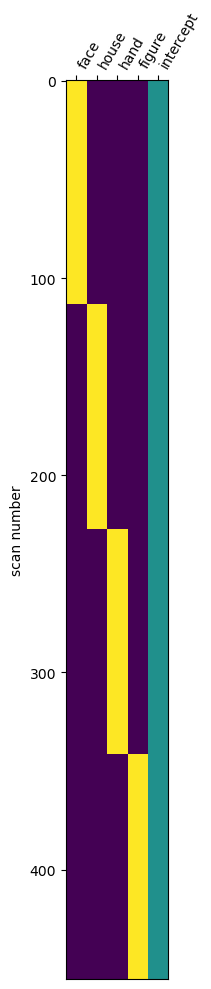

In [21]:
plot_design_matrix(X)

In [22]:
# Fit the second level model
second_level = SecondLevelModel().fit(all_imgs, design_matrix=X)

# Whole brain

In [23]:
z_maps_WB = {}

In [24]:
for cat in categories:
    z_maps_WB[cat] = second_level.compute_contrast(cat, output_type='z_score')
z_maps_WB['mean_effect'] = second_level.compute_contrast('intercept', output_type='z_score')

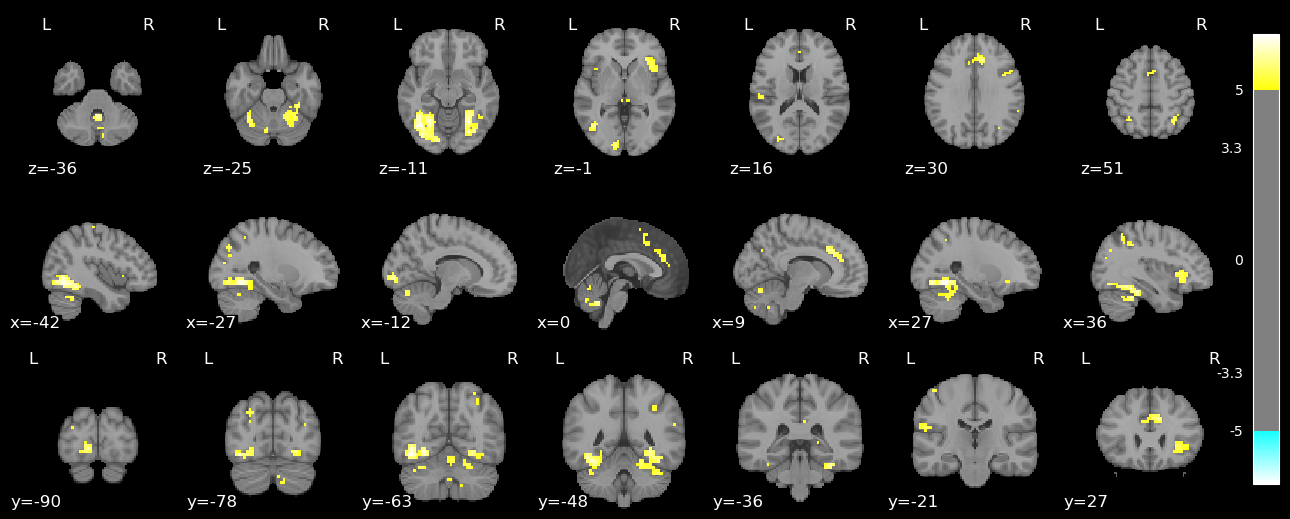

In [25]:
plot_stat_map(z_maps_WB['mean_effect'], threshold=SC_WB_threshold, black_bg=True, display_mode='mosaic')

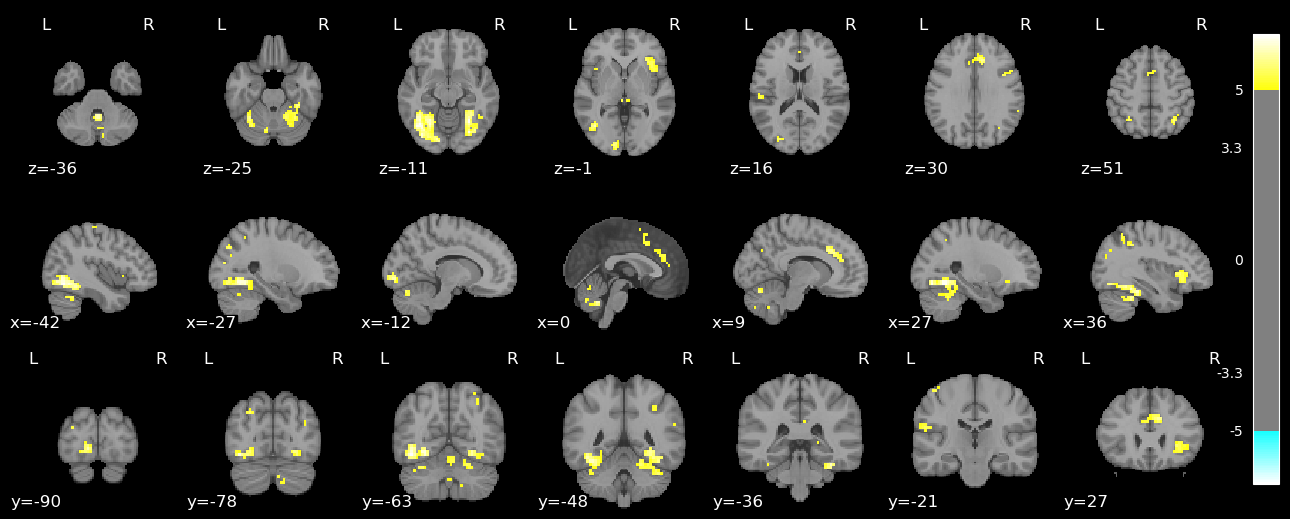

In [26]:
plot_stat_map(SC_WB_zmap, threshold=SC_WB_threshold, black_bg=True, display_mode='mosaic', title='')

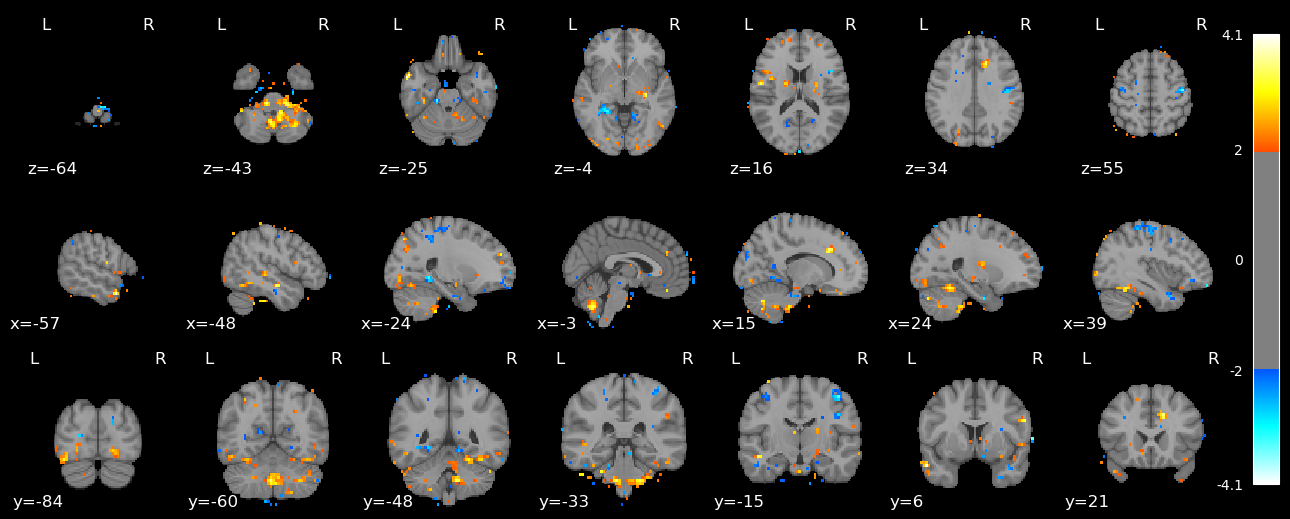

In [27]:
plot_stat_map(z_maps_WB['face'], threshold=2, black_bg=True, display_mode='mosaic')

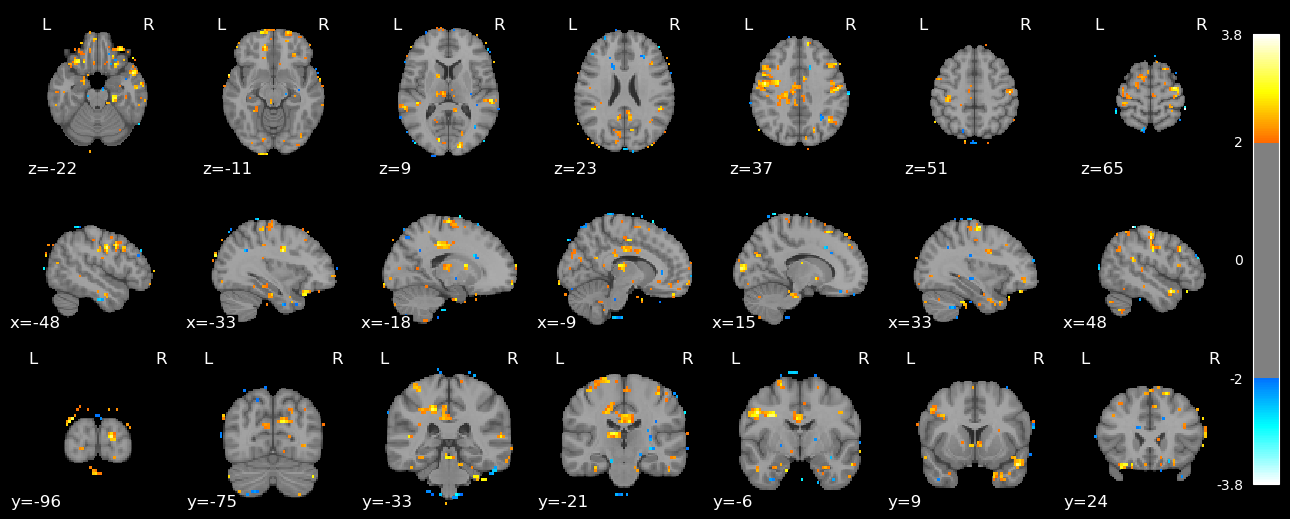

In [28]:
plot_stat_map(z_maps_WB['house'], threshold=2, black_bg=True, display_mode='mosaic')

# Fusiform area

In [29]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
fusiform_mask = os.path.join(mask_dir, 'fusiform_mask.nii.gz')
fusiform_mask = image.load_img(fusiform_mask)
fusiform_mask = image.resample_to_img(fusiform_mask, z_maps_WB['mean_effect'], interpolation='nearest') 

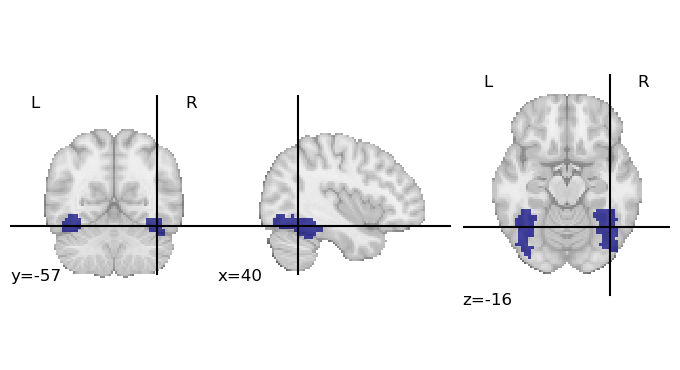

In [30]:
from nilearn.plotting import plot_roi
plot_roi(fusiform_mask)

In [31]:
ffa_second_lvl= SecondLevelModel(mask_img=fusiform_mask).fit(all_imgs, design_matrix=X)

In [32]:
ffa_face_zmap = ffa_second_lvl.compute_contrast('face',output_type=statistic)

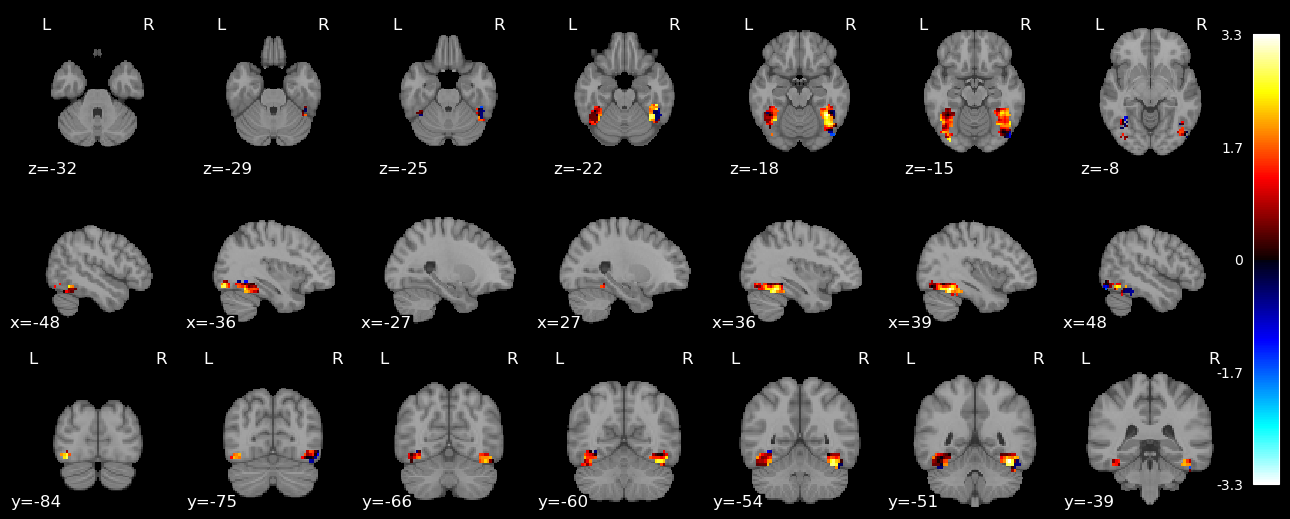

In [33]:
plot_stat_map(ffa_face_zmap, black_bg=True, display_mode='mosaic', title='')

In [34]:
ffa_face_thresholded_zmap, ffa_face_threshold = threshold_stats_img(ffa_face_zmap, alpha=0.001, height_control='fpr')#alpha, height_control='fdr')
print(f"FFA face threshold: {ffa_face_threshold:.3f}")

FFA face threshold: 3.291


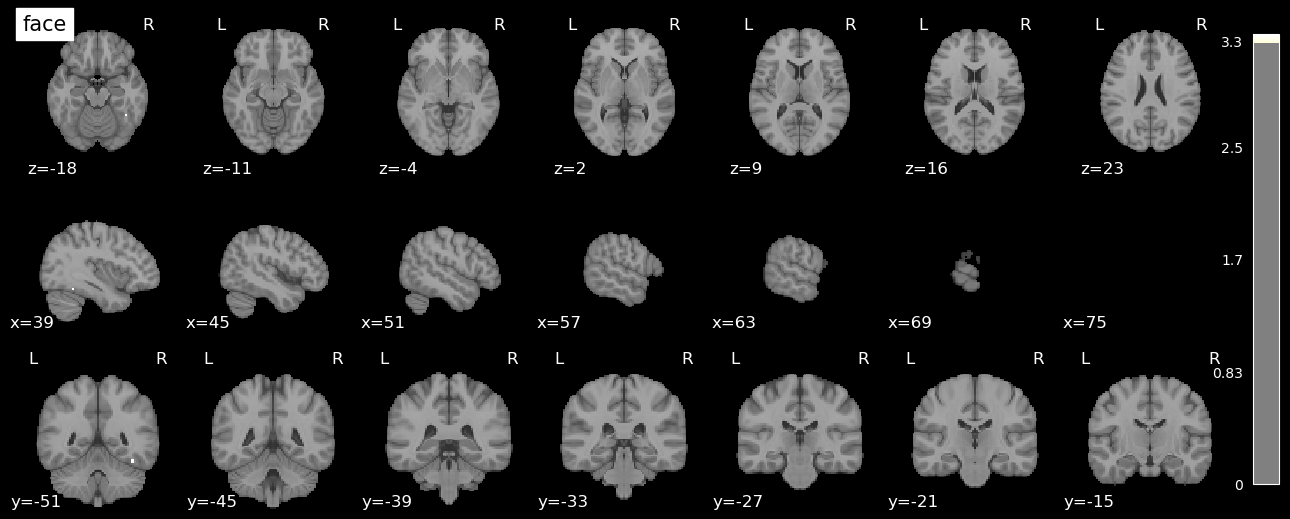

In [35]:
plot_stat_map(ffa_face_thresholded_zmap, threshold=ffa_face_threshold,
               black_bg=True, display_mode='mosaic', title='face')

# Other category for comparison

In [36]:
ffa_house_zmap = ffa_second_lvl.compute_contrast('house',output_type=statistic)

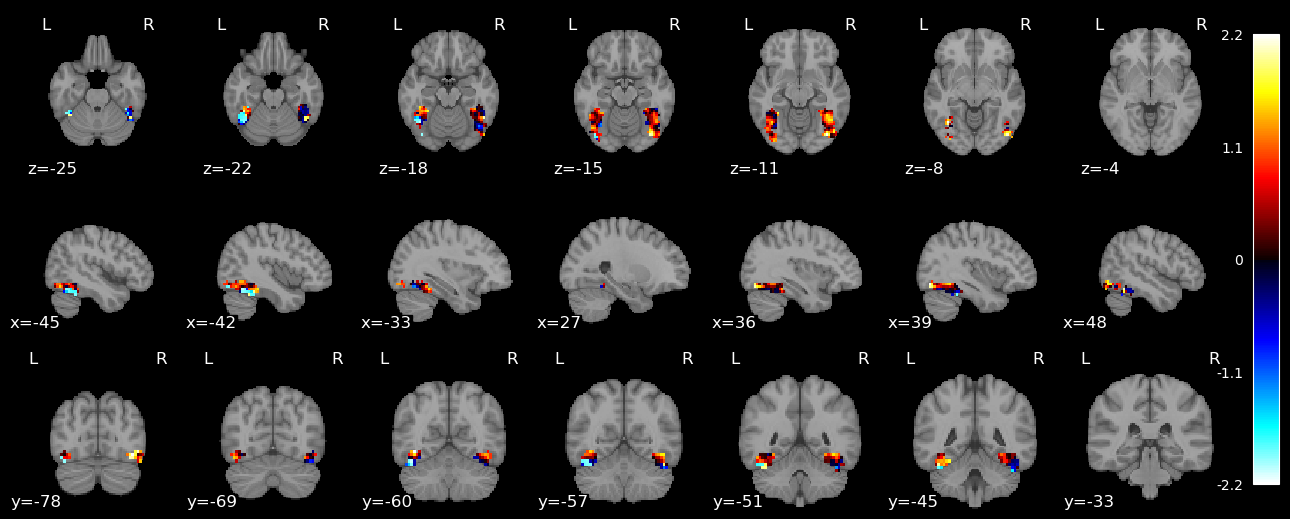

In [37]:
plot_stat_map(ffa_house_zmap, black_bg=True, display_mode='mosaic', title='')

In [38]:
ffa_hand_zmap = ffa_second_lvl.compute_contrast('hand',output_type=statistic)

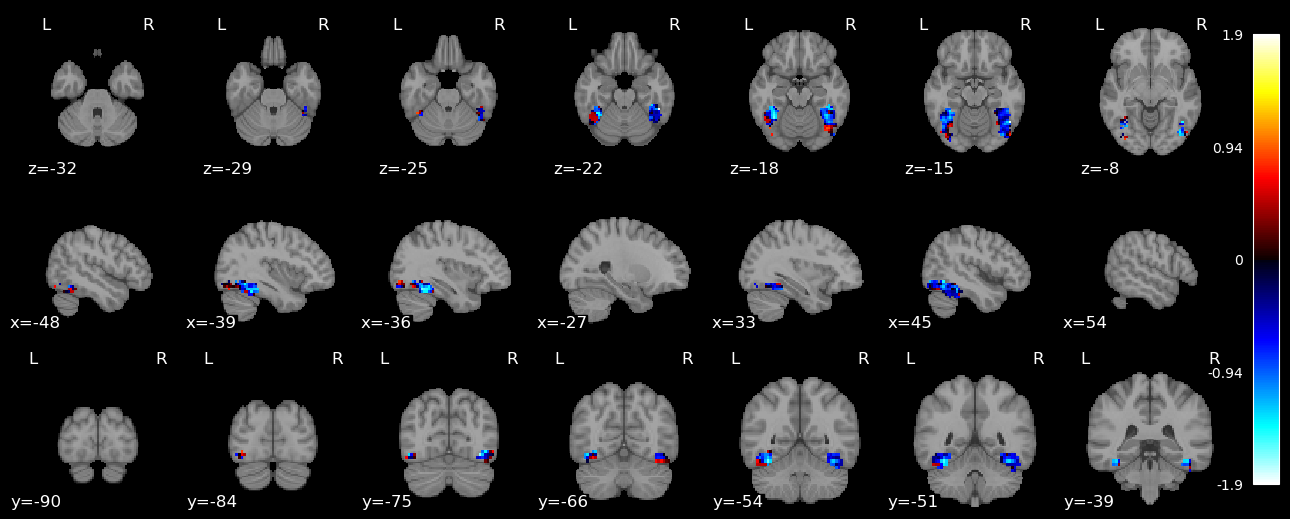

In [39]:
plot_stat_map(ffa_hand_zmap, black_bg=True, display_mode='mosaic', title='')